In [2]:
import sys
sys.path.insert(0, '/Users/nina/Documents/treemap/treemap/analysis')
from config_figures import *

In [17]:
from sklearn.preprocessing import StandardScaler#, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score
#from yellowbrick.cluster import KElbowVisualizer

In [18]:
# get ordination and covariate data
df = pd.read_csv('../../data/ordinations_biome_covariates_1981_2010.csv').drop(['system:index', '.geo'], axis=1)
df

,Axis1,Axis2,Axis3,CHELSA_bio12_1981_2010_V2_1,CHELSA_bio15_1981_2010_V2_1,CHELSA_bio1_1981_2010_V2_1,CHELSA_bio4_1981_2010_V2_1,CHELSA_gsl_1981_2010_V2_1,CHELSA_npp_1981_2010_V2_1,MDS1,MDS2,MDS3,SG_Coarse_fragments_005cm,SG_Silt_Content_005cm,SG_Soil_pH_H2O_005cm,biome,x,y
0,-0.203114,-0.110316,-0.109411,36432.962700,210.218000,2978.865000,502.012200,365.000000,25079.295200,0.647776,-0.294345,0.109215,1.709484,22.444225,42.883077,1.0,-85.5,0.5
1,-0.200630,-0.105294,-0.115464,35478.439800,194.474800,2980.997700,473.100500,365.000000,25182.618500,0.613397,-0.362359,0.128936,1.209468,23.118284,42.494265,1.0,-84.5,0.5
2,-0.202350,-0.105612,-0.112564,35496.315200,173.247700,2980.079300,450.927800,365.000000,25137.881300,0.650375,-0.368078,0.069564,1.495468,22.953371,42.309594,1.0,-83.5,0.5
3,-0.195576,-0.103767,-0.119640,35084.596800,177.327300,2982.499900,449.689900,365.000000,25254.789500,0.688352,-0.280964,0.089301,0.661833,23.515853,42.042120,1.0,-82.5,0.5
4,-0.197449,-0.111415,-0.126746,32617.759800,183.492400,2984.814600,454.145500,365.000000,25356.537500,0.597050,-0.399280,0.129519,0.530261,25.933236,41.885098,1.0,-81.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19530,0.263910,0.008874,-0.319804,3620.331081,849.427928,2562.133483,12368.610661,1.067568,1037.104204,-0.378482,0.375732,-0.424728,23.441461,37.014009,68.585201,11.0,-113.5,-95.5
19531,0.263910,0.008874,-0.319804,1784.820226,749.377556,2564.531692,13731.053108,37.862448,1067.435243,-0.393002,0.354893,-0.427902,29.631586,35.108469,69.331893,11.0,-105.5,-95.5
19532,0.263910,0.008874,-0.319804,1658.770470,703.070696,2565.979097,15418.188257,59.248569,1085.409666,-0.374453,0.381605,-0.423027,26.971516,35.174600,70.162665,11.0,-103.5,-95.5
19533,0.263910,0.008874,-0.319804,1650.206162,712.858674,2560.454655,16089.408171,61.398660,1017.978433,-0.373773,0.390479,-0.419074,25.536506,34.422878,70.305304,11.0,-102.5,-95.5


In [19]:
# compute PCA on environmental covariates
df_covs = df[[
    'CHELSA_bio12_1981_2010_V2_1', 'CHELSA_bio15_1981_2010_V2_1', 'CHELSA_bio1_1981_2010_V2_1', 
    'CHELSA_bio4_1981_2010_V2_1', 'CHELSA_gsl_1981_2010_V2_1', 'CHELSA_npp_1981_2010_V2_1', 
    'SG_Coarse_fragments_005cm', 'SG_Silt_Content_005cm', 'SG_Soil_pH_H2O_005cm'
]]
df_st = StandardScaler().fit_transform(df_covs)
pcamodel = PCA(n_components=2)
pca = pd.DataFrame(pcamodel.fit_transform(df_st)).rename(columns = {0:'pc1', 1:'pc2'})
scaled_pca = pca * (1.0 / (pca.max(axis=0) - pca.min(axis=0)))
scaled_pca

,pc1,pc2
0,0.519329,-0.224109
1,0.516155,-0.228333
2,0.516107,-0.232090
3,0.516226,-0.234137
4,0.500043,-0.235580
...,...,...
19530,-0.361684,0.028683
19531,-0.374036,0.021606
19532,-0.377825,0.002126
19533,-0.382103,0.000813


In [20]:
# compute variance explained by PCs
pca_variance_explained = pd.Series(pcamodel.explained_variance_ratio_, index=['pc1','pc2'])
pca_variance_explained

pc1    0.438662
pc2    0.265299
dtype: float64

In [21]:
# compute loadings of environmental covariates in PC space
pca_loadings = pd.DataFrame(pcamodel.components_.T, index = df_covs.columns, columns=['pc1','pc2'])
pca_loadings['var_name'] = ['Annual P', 'P season', 'MAT', 'T season', 'GSL', 'NPP', 'CF', 'Silt', 'pH']
pca_loadings

,pc1,pc2,var_name
CHELSA_bio12_1981_2010_V2_1,0.396485,-0.255254,Annual P
CHELSA_bio15_1981_2010_V2_1,-0.015762,0.472781,P season
CHELSA_bio1_1981_2010_V2_1,0.389413,0.360790,MAT
CHELSA_bio4_1981_2010_V2_1,-0.437969,-0.244097,T season
CHELSA_gsl_1981_2010_V2_1,0.431547,-0.219677,GSL
CHELSA_npp_1981_2010_V2_1,0.481241,-0.116788,NPP
SG_Coarse_fragments_005cm,-0.094442,0.053298,CF
SG_Silt_Content_005cm,-0.215826,-0.453108,Silt
SG_Soil_pH_H2O_005cm,-0.160516,0.501523,pH


In [22]:
# merge ordinations with PCA dataframe
df2 = scaled_pca.join(df[['MDS1','MDS2','MDS3','Axis1','Axis2','Axis3','x','y','biome']])
df2

,pc1,pc2,MDS1,MDS2,MDS3,Axis1,Axis2,Axis3,x,y,biome
0,0.519329,-0.224109,0.647776,-0.294345,0.109215,-0.203114,-0.110316,-0.109411,-85.5,0.5,1.0
1,0.516155,-0.228333,0.613397,-0.362359,0.128936,-0.200630,-0.105294,-0.115464,-84.5,0.5,1.0
2,0.516107,-0.232090,0.650375,-0.368078,0.069564,-0.202350,-0.105612,-0.112564,-83.5,0.5,1.0
3,0.516226,-0.234137,0.688352,-0.280964,0.089301,-0.195576,-0.103767,-0.119640,-82.5,0.5,1.0
4,0.500043,-0.235580,0.597050,-0.399280,0.129519,-0.197449,-0.111415,-0.126746,-81.5,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...
19530,-0.361684,0.028683,-0.378482,0.375732,-0.424728,0.263910,0.008874,-0.319804,-113.5,-95.5,11.0
19531,-0.374036,0.021606,-0.393002,0.354893,-0.427902,0.263910,0.008874,-0.319804,-105.5,-95.5,11.0
19532,-0.377825,0.002126,-0.374453,0.381605,-0.423027,0.263910,0.008874,-0.319804,-103.5,-95.5,11.0
19533,-0.382103,0.000813,-0.373773,0.390479,-0.419074,0.263910,0.008874,-0.319804,-102.5,-95.5,11.0


In [23]:
# scale ordinations (10-90% quantiles mapped to 0-1) for colors
def scale_to_0_1(vec):
    q10 = vec.quantile(0.1)
    q90 = vec.quantile(0.9)
    return vec.apply(lambda x: min(max((x-q10)/(q90-q10), 0), 1))

df2[['MDS1_red','MDS2_green','MDS3_blue']] = df2[['MDS1','MDS2','MDS3']].apply(scale_to_0_1)
nmds_colors = np.array(df2[['MDS1_red','MDS2_green','MDS3_blue']])
df2[['Axis1_green','Axis2_red','Axis3_blue']] = df2[['Axis1','Axis2','Axis3']].apply(scale_to_0_1)
evopca_colors = np.array(df2[['Axis2_red','Axis1_green', 'Axis3_blue']])
df2

,pc1,pc2,MDS1,MDS2,MDS3,Axis1,Axis2,Axis3,x,y,biome,MDS1_red,MDS2_green,MDS3_blue,Axis1_green,Axis2_red,Axis3_blue
0,0.519329,-0.224109,0.647776,-0.294345,0.109215,-0.203114,-0.110316,-0.109411,-85.5,0.5,1.0,1.000000,0.000000,0.672169,0.000000,0.065651,0.568248
1,0.516155,-0.228333,0.613397,-0.362359,0.128936,-0.200630,-0.105294,-0.115464,-84.5,0.5,1.0,1.000000,0.000000,0.707371,0.000000,0.079729,0.552604
2,0.516107,-0.232090,0.650375,-0.368078,0.069564,-0.202350,-0.105612,-0.112564,-83.5,0.5,1.0,1.000000,0.000000,0.601389,0.000000,0.078836,0.560098
3,0.516226,-0.234137,0.688352,-0.280964,0.089301,-0.195576,-0.103767,-0.119640,-82.5,0.5,1.0,1.000000,0.022467,0.636620,0.000000,0.084007,0.541811
4,0.500043,-0.235580,0.597050,-0.399280,0.129519,-0.197449,-0.111415,-0.126746,-81.5,0.5,1.0,1.000000,0.000000,0.708413,0.000000,0.062570,0.523447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19530,-0.361684,0.028683,-0.378482,0.375732,-0.424728,0.263910,0.008874,-0.319804,-113.5,-95.5,11.0,0.089351,1.000000,0.000000,0.509548,0.399737,0.024503
19531,-0.374036,0.021606,-0.393002,0.354893,-0.427902,0.263910,0.008874,-0.319804,-105.5,-95.5,11.0,0.074909,1.000000,0.000000,0.509548,0.399737,0.024503
19532,-0.377825,0.002126,-0.374453,0.381605,-0.423027,0.263910,0.008874,-0.319804,-103.5,-95.5,11.0,0.093358,1.000000,0.000000,0.509548,0.399737,0.024503
19533,-0.382103,0.000813,-0.373773,0.390479,-0.419074,0.263910,0.008874,-0.319804,-102.5,-95.5,11.0,0.094035,1.000000,0.000000,0.509548,0.399737,0.024503


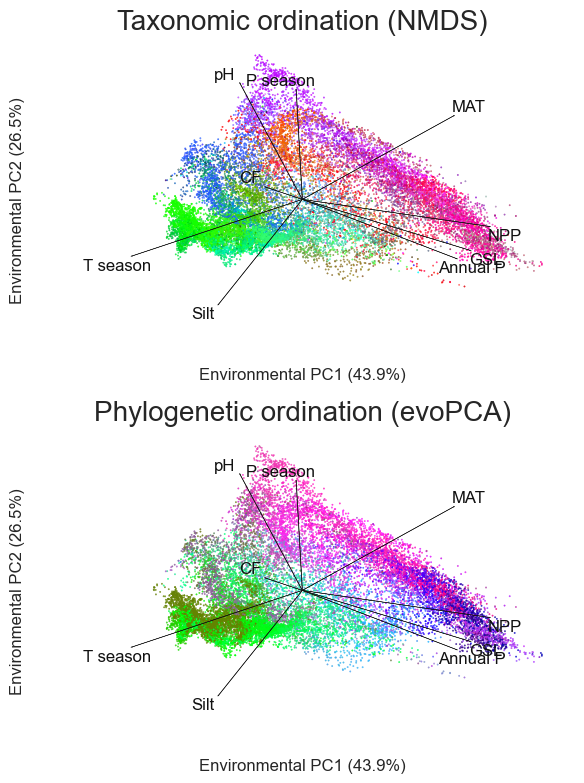

In [24]:
# figure with ordinations mapped into PC space 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,8))

ax1.scatter(x=df2['pc1'], y=df2['pc2'], c=nmds_colors, s=1, alpha=0.8)
ax1.set_title('Taxonomic ordination (NMDS)', fontsize=20)
ax2.scatter(x=df2['pc1'], y=df2['pc2'], c=evopca_colors, s=1, alpha=0.8)
ax2.set_title('Phylogenetic ordination (evoPCA)', fontsize=20)

for ax in [ax1, ax2]:
    ax.set_xlabel("Environmental PC1 (" + str(pca_variance_explained.pc1.round(3) * 100) + "%)", fontsize=12)
    ax.set_ylabel( "Environmental PC2 (" + str(pca_variance_explained.pc2.round(3) * 100) + "%)", fontsize=12)
    for r in pca_loadings.iterrows():
        ax.arrow(0, 0, r[1]['pc1'], r[1]['pc2'], color = 'k')
        text_x = r[1]['pc1'] + 0.04 if r[1]['pc1'] >= 0 else r[1]['pc1'] - 0.04
        text_y = r[1]['pc2'] + 0.04 if r[1]['pc2'] >= 0 else r[1]['pc2'] - 0.04
        ax.text(text_x, text_y, r[1]['var_name'], color = 'k', ha = 'center', va = 'center', fontsize=12)
    ax.set(xlim = (-0.7, 0.7), ylim = (-0.7, 0.7), xticklabels=[], xticks=[], yticklabels=[], yticks=[])
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.savefig('../../figures/nmds_evopca_pca.png')

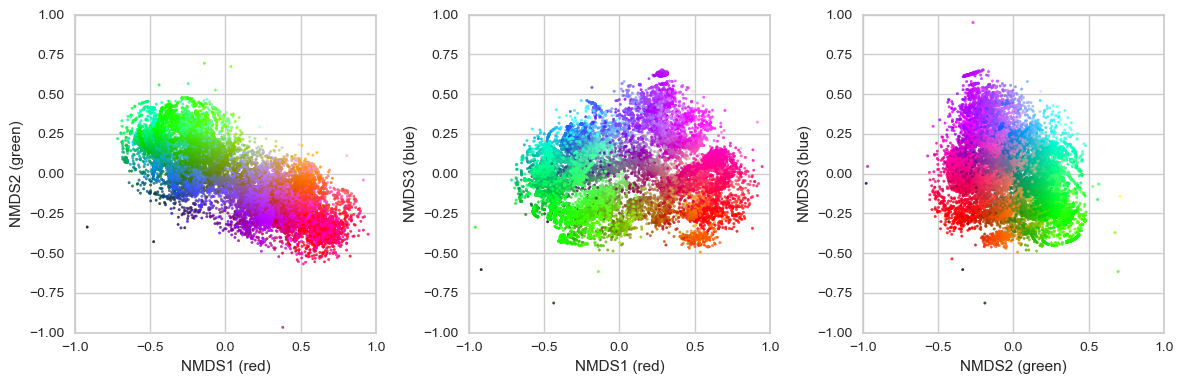

In [25]:
lim = (-1, 1)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

ax1.scatter(df2['MDS1'], df2['MDS2'], s=3, alpha=0.8, c=nmds_colors)
ax1.set(xlabel ='NMDS1 (red)', ylabel='NMDS2 (green)', xlim=lim, ylim=lim)

ax2.scatter(df2['MDS1'], df2['MDS3'], s=3, alpha=0.8, c=nmds_colors)
ax2.set(xlabel = 'NMDS1 (red)', ylabel='NMDS3 (blue)', xlim=lim, ylim=lim)

ax3.scatter(df2['MDS2'], df2['MDS3'], s=3, alpha=0.8, c=nmds_colors)
ax3.set(xlabel = 'NMDS2 (green)', ylabel='NMDS3 (blue)', xlim=lim, ylim=lim)

plt.tight_layout()
plt.show()

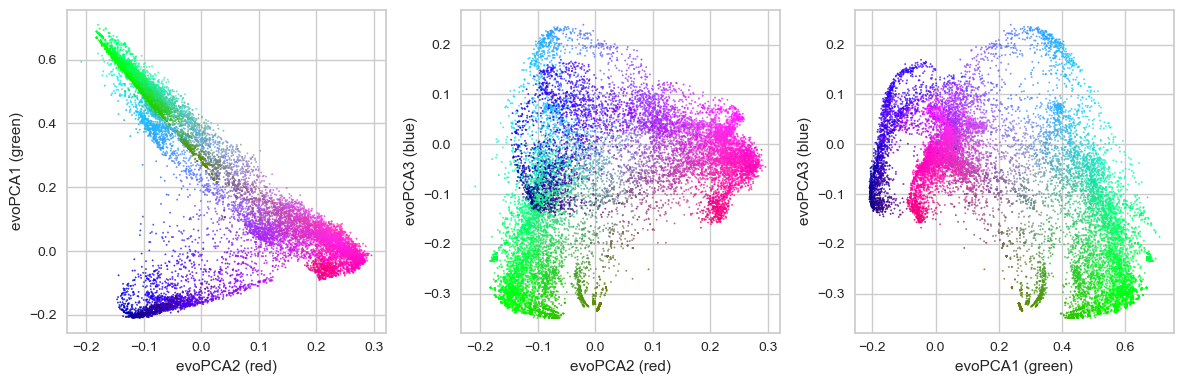

In [128]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

ax1.scatter(df2['Axis2'], df2['Axis1'], c=evopca_colors, s=1, alpha=0.8)
ax1.set(xlabel ='evoPCA2 (red)', ylabel='evoPCA1 (green)')

ax2.scatter(df2['Axis2'], df2['Axis3'], c=evopca_colors, s=1, alpha=0.8)
ax2.set(xlabel = 'evoPCA2 (red)', ylabel='evoPCA3 (blue)')

ax3.scatter(df2['Axis1'], df2['Axis3'], c=evopca_colors, s=1, alpha=0.8)
ax3.set(xlabel = 'evoPCA1 (green)', ylabel='evoPCA3 (blue)')

plt.tight_layout()
plt.show()

In [190]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df2[['MDS1','MDS2','MDS3','Axis1','Axis2','Axis3']]), columns = ['MDS1','MDS2','MDS3','Axis1','Axis2','Axis3'])
df_scaled

,MDS1,MDS2,MDS3,Axis1,Axis2,Axis3
0,0.909743,-0.530542,0.253788,-1.881515,-0.981266,0.093627
1,0.861461,-0.653135,0.299614,-1.871249,-0.942657,0.052966
2,0.913393,-0.663444,0.161649,-1.878358,-0.945104,0.072444
3,0.966728,-0.506425,0.207512,-1.850355,-0.930924,0.024915
4,0.838502,-0.719684,0.300970,-1.858097,-0.989714,-0.022812
...,...,...,...,...,...,...
19530,-0.531544,0.677239,-0.986959,0.049029,-0.065039,-1.319579
19531,-0.551935,0.639677,-0.994336,0.049029,-0.065039,-1.319579
19532,-0.525885,0.687825,-0.983008,0.049029,-0.065039,-1.319579
19533,-0.524930,0.703819,-0.973821,0.049029,-0.065039,-1.319579


In [196]:
# remove outliers from ordinations
q1 = df_scaled.quantile(0.05)
q3 = df_scaled.quantile(0.95)
iqr = q3 - q1
df_nooutliers = df_scaled[df_scaled.apply(lambda x: (x >= q1[x.name] - 1.5*iqr[x.name]) & (x <= q3[x.name] + 1.5*iqr[x.name])).all(axis=1)]
df_nooutliers

,MDS1,MDS2,MDS3,Axis1,Axis2,Axis3
0,0.909743,-0.530542,0.253788,-1.881515,-0.981266,0.093627
1,0.861461,-0.653135,0.299614,-1.871249,-0.942657,0.052966
2,0.913393,-0.663444,0.161649,-1.878358,-0.945104,0.072444
3,0.966728,-0.506425,0.207512,-1.850355,-0.930924,0.024915
4,0.838502,-0.719684,0.300970,-1.858097,-0.989714,-0.022812
...,...,...,...,...,...,...
19530,-0.531544,0.677239,-0.986959,0.049029,-0.065039,-1.319579
19531,-0.551935,0.639677,-0.994336,0.049029,-0.065039,-1.319579
19532,-0.525885,0.687825,-0.983008,0.049029,-0.065039,-1.319579
19533,-0.524930,0.703819,-0.973821,0.049029,-0.065039,-1.319579


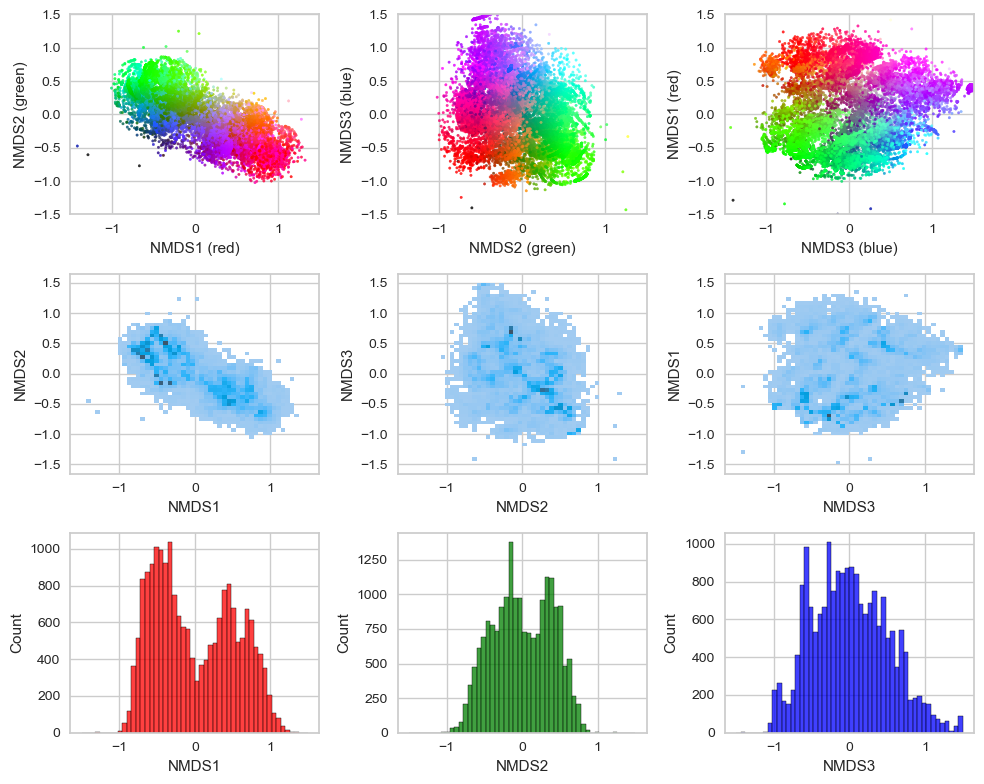

In [197]:
lim = (-1.5, 1.5)
nbins = 50

fig, (row1, row2, row3) = plt.subplots(3, 3, figsize=(10,8))

ax1, ax2, ax3 = row1
ax1.scatter(df_scaled['MDS1'], df_scaled['MDS2'], s=3, alpha=0.8, c=nmds_colors)
ax1.set(xlabel ='NMDS1 (red)', ylabel='NMDS2 (green)', xlim=lim, ylim=lim)
ax2.scatter(df_scaled['MDS2'], df_scaled['MDS3'], s=3, alpha=0.8, c=nmds_colors)
ax2.set(xlabel = 'NMDS2 (green)', ylabel='NMDS3 (blue)', xlim=lim, ylim=lim)
ax3.scatter(df_scaled['MDS3'], df_scaled['MDS1'], s=3, alpha=0.8, c=nmds_colors)
ax3.set(xlabel = 'NMDS3 (blue)', ylabel='NMDS1 (red)', xlim=lim, ylim=lim)

ax1,ax2, ax3 = row2
sns.histplot(df_nooutliers, x='MDS1', y='MDS2', bins=nbins, binrange=lim, ax=ax1)
ax1.set(xlabel='NMDS1', ylabel='NMDS2')
sns.histplot(df_nooutliers, x='MDS2', y='MDS3', bins=nbins, binrange=lim, ax=ax2)
ax2.set(xlabel='NMDS2', ylabel='NMDS3')
sns.histplot(df_nooutliers, x='MDS3', y='MDS1', bins=nbins, binrange=lim, ax=ax3)
ax3.set(xlabel='NMDS3', ylabel='NMDS1')

ax1, ax2, ax3 = row3
sns.histplot(df_scaled, x='MDS1', bins=nbins, binrange=lim, color='red', ax=ax1)
ax1.set(xlabel ='NMDS1')
sns.histplot(df_scaled, x='MDS2', bins=nbins, binrange=lim, color='green', ax=ax2)
ax2.set(xlabel ='NMDS2')
sns.histplot(df_scaled, x='MDS3', bins=nbins, binrange=lim, color='blue', ax=ax3)
ax3.set(xlabel ='NMDS3')

plt.tight_layout()
plt.show()

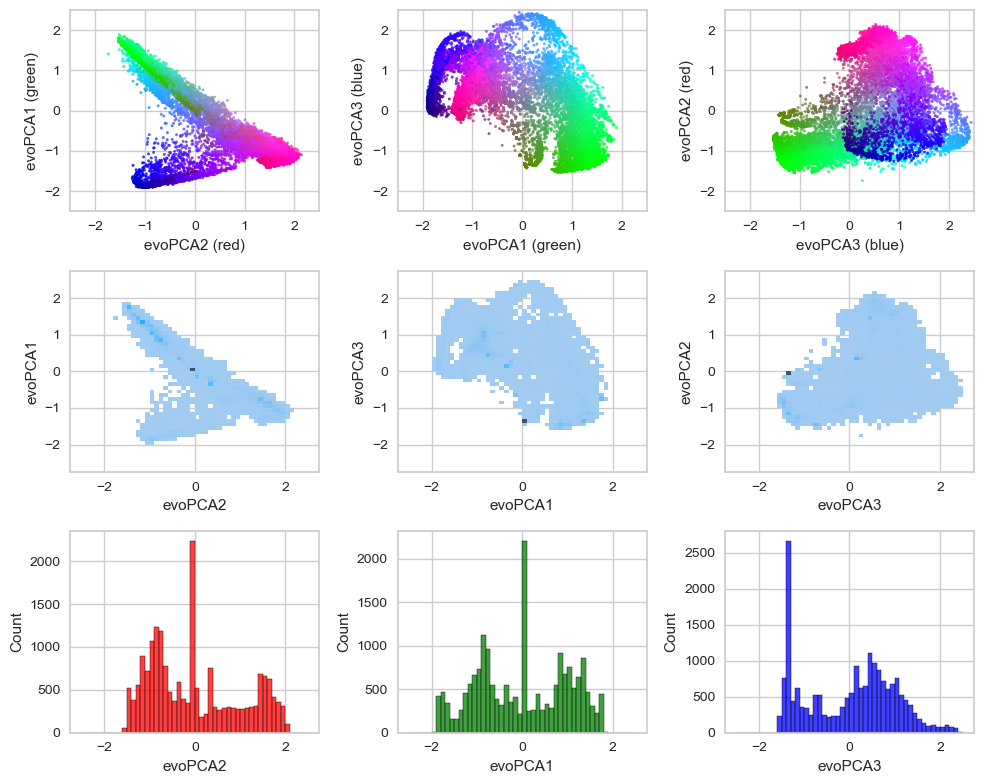

In [205]:
lim = (-2.5,2.5)
nbins = 50
fig, (row1, row2, row3) = plt.subplots(3, 3, figsize=(10,8))

ax1, ax2, ax3 = row1
ax1.scatter(df_scaled['Axis2'], df_scaled['Axis1'], s=3, alpha=0.8, c=evopca_colors)
ax1.set(xlabel ='evoPCA2 (red)', ylabel='evoPCA1 (green)', xlim=lim, ylim=lim)
ax2.scatter(df_scaled['Axis1'], df_scaled['Axis3'], s=3, alpha=0.8, c=evopca_colors)
ax2.set(xlabel = 'evoPCA1 (green)', ylabel='evoPCA3 (blue)', xlim=lim, ylim=lim)
ax3.scatter(df_scaled['Axis3'], df_scaled['Axis2'], s=3, alpha=0.8, c=evopca_colors)
ax3.set(xlabel = 'evoPCA3 (blue)', ylabel='evoPCA2 (red)', xlim=lim, ylim=lim)

ax1,ax2, ax3 = row2
sns.histplot(df_nooutliers, x='Axis2', y='Axis1', bins=nbins, binrange=lim, ax=ax1)
ax1.set(xlabel='evoPCA2', ylabel='evoPCA1')
sns.histplot(df_nooutliers, x='Axis1', y='Axis3', bins=nbins, binrange=lim, ax=ax2)
ax2.set(xlabel='evoPCA1', ylabel='evoPCA3')
sns.histplot(df_nooutliers, x='Axis3', y='Axis2', bins=nbins, binrange=lim, ax=ax3)
ax3.set(xlabel='evoPCA3', ylabel='evoPCA2')

ax1, ax2, ax3 = row3
sns.histplot(df_scaled, x='Axis2', bins=nbins, binrange=lim, color='red', ax=ax1)
ax1.set(xlabel ='evoPCA2')
sns.histplot(df_scaled, x='Axis1', bins=nbins, binrange=lim, color='green', ax=ax2)
ax2.set(xlabel ='evoPCA1')
sns.histplot(df_scaled, x='Axis3', bins=nbins, binrange=lim, color='blue', ax=ax3)
ax3.set(xlabel ='evoPCA3')

plt.tight_layout()
plt.show()